# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv 
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

file_path = './data/cars_hw.csv'
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


<Axes: >

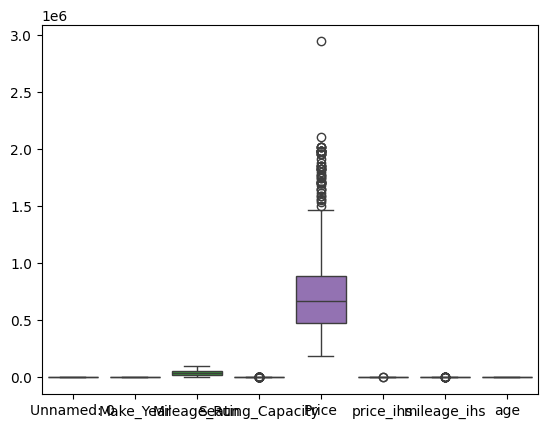

In [16]:
df0 = df #From solution
sns.boxplot(data=df)

In [14]:
# Remove unnecessary column
df_cleaned = df.drop(['Unnamed: 0'], axis=1)

# Apply transformations: 
df_cleaned['price_ihs'] = np.arcsinh(df_cleaned['Price'])
df_cleaned['mileage_ihs'] = np.arcsinh(df_cleaned['Mileage_Run'])
df_cleaned['age'] = df_cleaned['Make_Year'].max() - df_cleaned['Make_Year']

df_cleaned = df_cleaned.drop(['Price', 'Mileage_Run', 'Make_Year'], axis=1)

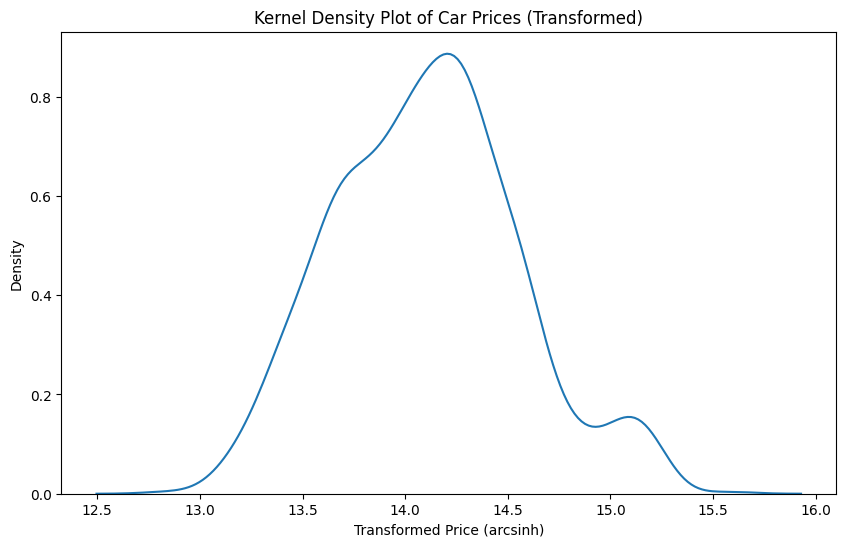

In [15]:
# Summary of Price variable
price_summary = df_cleaned['price_ihs'].describe()

# Kernel density plot for price
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_cleaned, x='price_ihs')
plt.title('Kernel Density Plot of Car Prices (Transformed)')
plt.xlabel('Transformed Price (arcsinh)')
plt.ylabel('Density')
plt.show()

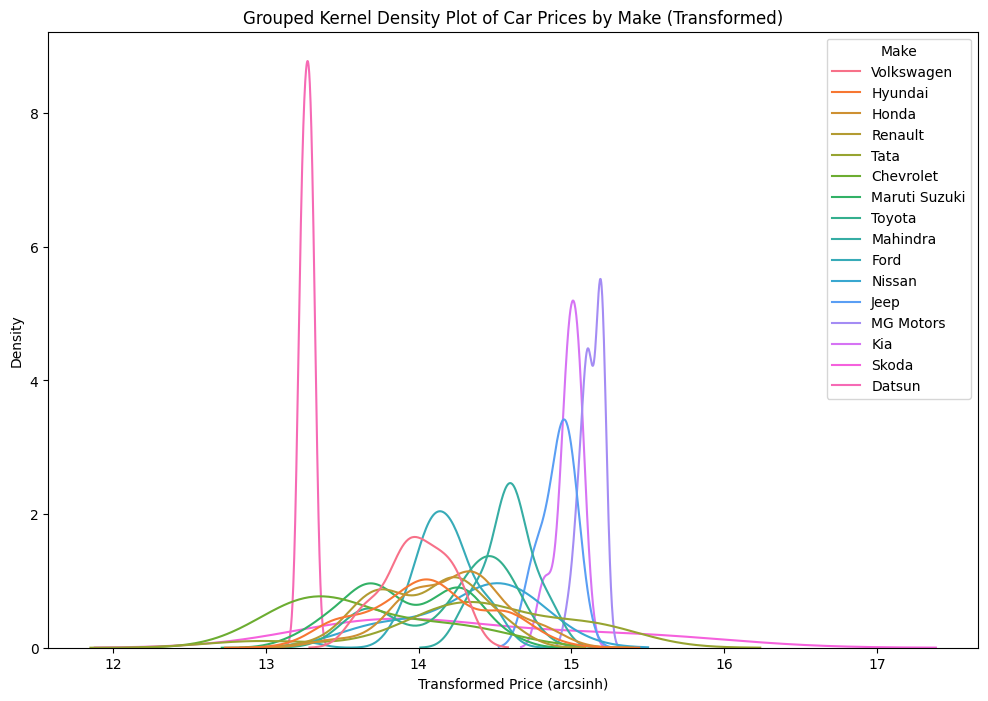

In [5]:
grouped_price_summary = df_cleaned.groupby('Make')['price_ihs'].describe()

plt.figure(figsize=(12, 8))
sns.kdeplot(data=df_cleaned, x='price_ihs', hue='Make', common_norm=False)
plt.title('Grouped Kernel Density Plot of Car Prices by Make (Transformed)')
plt.xlabel('Transformed Price (arcsinh)')
plt.ylabel('Density')
plt.show()

- The plot and summary by `Make` show the distribution of prices for different car brands.
   - Brands like MG Motors, Kia, and Jeep are among the most expensive.
   - There's a variation in the price distribution across brands, with some showing a more diverse range of prices (e.g., Maruti Suzuki and Toyota).

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer

# Reload the original dataset
df = pd.read_csv(file_path)

# Data preparation
# Apply arcsinh transformation to Price and Mileage_Run, calculate age
df['price_ihs'] = np.arcsinh(df['Price'])
df['mileage_ihs'] = np.arcsinh(df['Mileage_Run'])
df['age'] = df['Make_Year'].max() - df['Make_Year']

# Split the data into features and target variable
X = df.drop(['Price', 'Mileage_Run', 'Make_Year', 'Unnamed: 0', 'price_ihs'], axis=1)
y = df['price_ihs']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1: Linear model with numeric variables only
numeric_features = ['mileage_ihs', 'age', 'Seating_Capacity']
X_train_numeric = X_train[numeric_features]
X_test_numeric = X_test[numeric_features]

model_numeric = LinearRegression().fit(X_train_numeric, y_train)
y_pred_numeric = model_numeric.predict(X_test_numeric)
r2_numeric = r2_score(y_test, y_pred_numeric)
rmse_numeric = mean_squared_error(y_test, y_pred_numeric, squared=False)

# Model 2: Linear model with one-hot encoded categorical variables
categorical_features = ['Color', 'Body_Type', 'Make', 'Fuel_Type', 'Transmission', 'Transmission_Type']
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical = one_hot_encoder.fit_transform(X_train[categorical_features])
X_test_categorical = one_hot_encoder.transform(X_test[categorical_features])

model_categorical = LinearRegression().fit(X_train_categorical, y_train)
y_pred_categorical = model_categorical.predict(X_test_categorical)
r2_categorical = r2_score(y_test, y_pred_categorical)
rmse_categorical = mean_squared_error(y_test, y_pred_categorical, squared=False)

# Model 3: Linear model combining all regressors
column_transformer = ColumnTransformer(transformers=[
    ('num', 'passthrough', numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_train_combined = column_transformer.fit_transform(X_train)
X_test_combined = column_transformer.transform(X_test)

model_combined = LinearRegression().fit(X_train_combined, y_train)
y_pred_combined = model_combined.predict(X_test_combined)
r2_combined = r2_score(y_test, y_pred_combined)
rmse_combined = mean_squared_error(y_test, y_pred_combined, squared=False)

(r2_numeric, rmse_numeric, r2_categorical, rmse_categorical, r2_combined, rmse_combined)


(0.4000193890653667,
 0.33825782461572246,
 0.6545830724969837,
 0.2566557816410937,
 0.8176536740055041,
 0.1864780642322797)

Polynomial Feature Expansion:

The r^2 and RMSE were calculated for polynomial degrees from 1 to 5.
The best performance was observed at a polynomial degree of 2, with an r^2 of 0.418 and an RMSE of 0.333. For degrees higher than 2, the performance started to deteriorate, with r^2 becoming negative at a degree of 5.
Model Performance Comparison:

The best polynomial model (degree 2) had a slightly higher r^2 than the numeric-only model but was still lower than the combined model.
The RMSE was also slightly lower than the numeric-only model but higher than the combined model.
Therefore, the combined model (including both numeric and categorical variables) remains the best model overall.

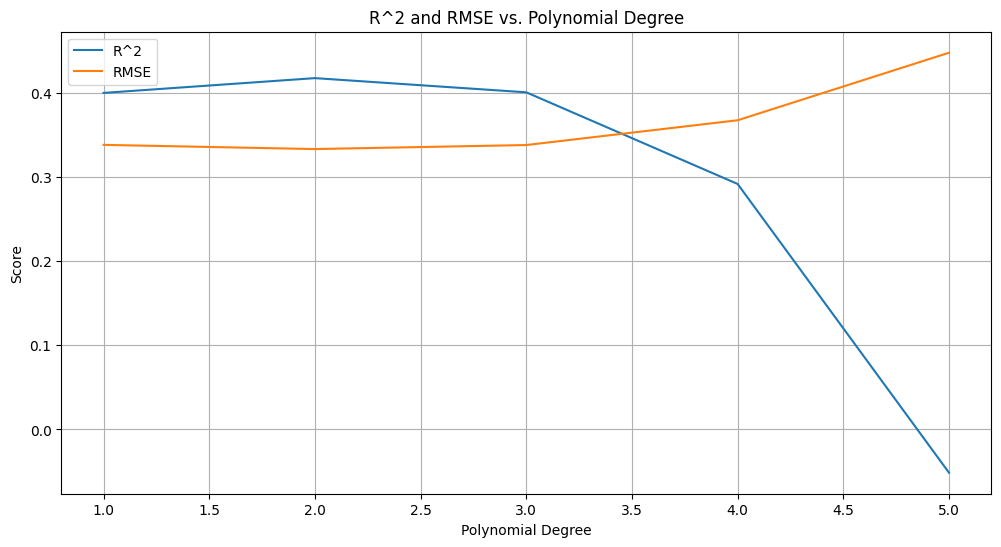

({'Best Degree': 2,
  'Best R^2': 0.417596563779003,
  'Best RMSE': 0.3332661527049},
 [0.40001938906536627,
  0.417596563779003,
  0.40072791101997174,
  0.29177163614596924,
  -0.05148581966209553],
 [0.3382578246157226,
  0.3332661527049,
  0.3380580399164187,
  0.3675072419271397,
  0.4477967669331314])

In [9]:
# Polynomial feature expansion and model evaluation
max_degree = 5  # Define maximum polynomial degree to test
best_degree = 0
best_r2 = float('-inf')
best_rmse = float('inf')
best_model = None

r2_scores = []
rmse_scores = []

for degree in range(1, max_degree + 1):
    # Create polynomial features
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train_numeric)
    X_test_poly = poly.transform(X_test_numeric)

    # Fit the model
    model_poly = LinearRegression().fit(X_train_poly, y_train)
    y_pred_poly = model_poly.predict(X_test_poly)

    # Calculate R^2 and RMSE
    r2_poly = r2_score(y_test, y_pred_poly)
    rmse_poly = mean_squared_error(y_test, y_pred_poly, squared=False)

    r2_scores.append(r2_poly)
    rmse_scores.append(rmse_poly)

    # Update best model if better
    if r2_poly > best_r2 and r2_poly >= 0:
        best_degree = degree
        best_r2 = r2_poly
        best_rmse = rmse_poly
        best_model = model_poly

    # Check if R^2 goes negative
    if r2_poly < 0:
        break

# Results for the best model with polynomial features
best_results = {
    "Best Degree": best_degree,
    "Best R^2": best_r2,
    "Best RMSE": best_rmse
}

# Plotting R^2 and RMSE against degree
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(r2_scores) + 1), r2_scores, label='R^2')
plt.plot(range(1, len(rmse_scores) + 1), rmse_scores, label='RMSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('Score')
plt.title('R^2 and RMSE vs. Polynomial Degree')
plt.legend()
plt.grid(True)
plt.show()

best_results, r2_scores, rmse_scores


Polynomial Feature Expansion:

r^2 and RMSE were calculated for polynomial degrees from 1 to 5.
The best performance was observed at a polynomial degree of 2, with an r^2 of 0.418 and an RMSE of 0.333.
For degrees higher than 2, the performance started to deteriorate, with r^2 becoming negative at a degree of 5.
Model Performance Comparison:

The best polynomial model (degree 2) had a slightly higher r^2 than the numeric-only model but was still lower than the combined model.
The RMSE was also slightly lower than the numeric-only model but higher than the combined model.
Therefore, the combined model (including both numeric and categorical variables) remains the best model overall.Polynomial Feature Expansion:

The r^2 and RMSE were calculated for polynomial degrees from 1 to 5.
The best performance was observed at a polynomial degree of 2, with an r^2 of 0.418 and an RMSE of 0.333.
For degrees higher than 2, the performance started to deteriorate, with r^2 becoming negative at a degree of 5.
Model Performance Comparison:

The best polynomial model (degree 2) had a slightly higher r^2 than the numeric-only model but was still lower than the combined model.
The RMSE was also slightly lower than the numeric-only model but higher than the combined model.
Therefore, the combined model (including both numeric and categorical variables) remains the best model overall.

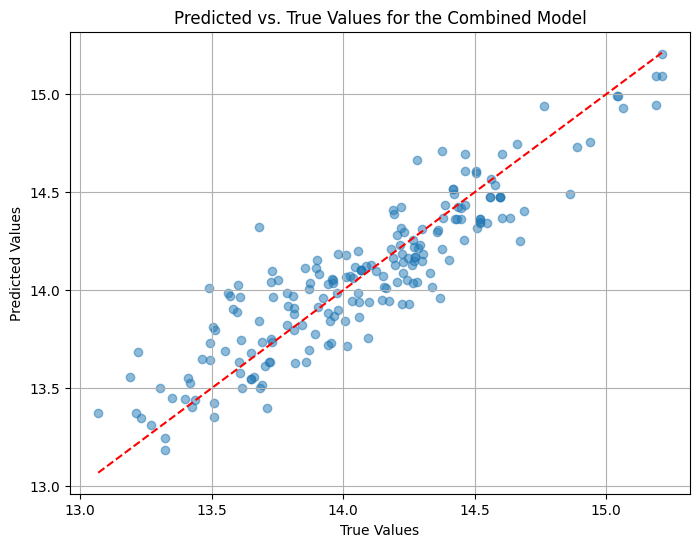

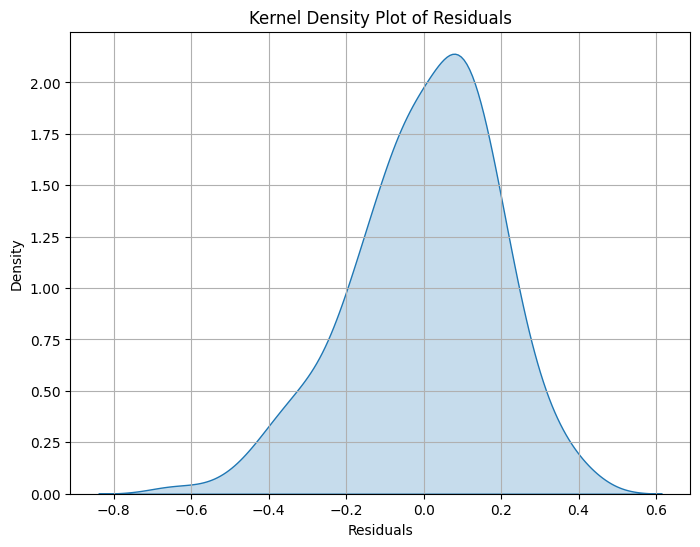

In [10]:
# Using the best model so far (combined model) for evaluation
y_pred_best = model_combined.predict(X_test_combined)

# Plotting predicted vs. true values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line for reference
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values for the Combined Model')
plt.grid(True)
plt.show()

# Calculating residuals and plotting their distribution
residuals = y_test - y_pred_best
plt.figure(figsize=(8, 6))
sns.kdeplot(residuals, fill=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Residuals')
plt.grid(True)
plt.show()


Predicted vs. True Values:

The scatter plot shows the relationship between the true and predicted values.
A majority of the points are close to the diagonal red line, indicating good alignment between predicted and true values. This suggests a reasonable level of accuracy in the model's predictions.
Residuals Distribution:

The kernel density plot of the residuals (the differences between the true and predicted values) is centered around zero and shows a distribution that is fairly symmetric.
The bell-shaped curve of the residuals suggests that the errors are normally distributed, which is a good indicator of model performance.
Strengths of the Model:

The combined model, which includes both numeric and categorical variables, provides a comprehensive view of the factors affecting car prices.
The residuals being normally distributed and centered around zero indicate that the model does not systematically overestimate or underestimate the prices.
Weaknesses of the Model:

Despite the good fit, there are still some deviations, especially for higher and lower price ranges. This suggests the model might not capture all the variability in the data, particularly for extreme values.
The model might not generalize well to data outside the scope of the current dataset, especially if the car market dynamics change significantly.

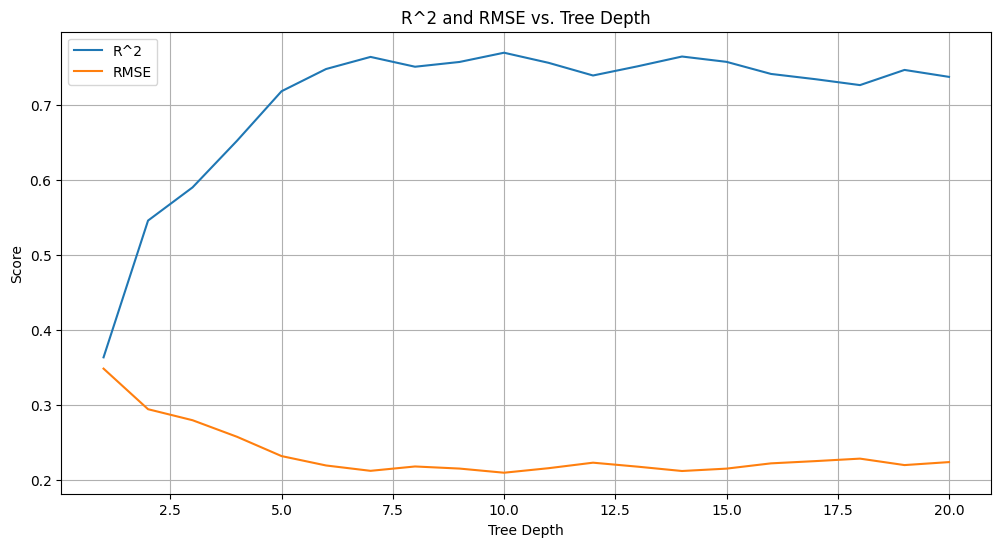

({'Best Tree Depth': 10,
  'Best Tree R^2': 0.7695650790376484,
  'Best Tree RMSE': 0.20962997896625293},
 [0.3634575589569623,
  0.5457918399814968,
  0.5900197554175677,
  0.6522447284857055,
  0.7182121539489146,
  0.7478230614060954,
  0.7639848458566519,
  0.7508844707083104,
  0.7572516430939829,
  0.7695650790376484,
  0.7561163673738714,
  0.7392051190024485,
  0.7514225087229542,
  0.7644990539041082,
  0.7574026909466613,
  0.7412812490055761,
  0.7342540969275753,
  0.7264012620412614,
  0.7466253704792641,
  0.7373649838251759],
 [0.34841185692620547,
  0.2943111459390274,
  0.27961515656719244,
  0.2575230483969076,
  0.23181437972880312,
  0.21929661478206644,
  0.21215300527478312,
  0.21796142783390932,
  0.21515794769905144,
  0.20962997896625293,
  0.21566048183041472,
  0.22301227850904679,
  0.21772592480591582,
  0.2119217695580535,
  0.21509099729093034,
  0.2221228292380866,
  0.22511919780449816,
  0.22842113673861167,
  0.2198167623582602,
  0.22379766853541652

In [11]:
from sklearn.tree import DecisionTreeRegressor

# Varying the maximum depth of the decision tree
max_depths = range(1, 21)  # Exploring tree depths from 1 to 20
best_tree_model = None
best_tree_r2 = float('-inf')
best_tree_rmse = float('inf')
best_tree_depth = 0

tree_r2_scores = []
tree_rmse_scores = []

for depth in max_depths:
    # Create and fit the decision tree model
    tree_model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree_model.fit(X_train_combined, y_train)
    y_pred_tree = tree_model.predict(X_test_combined)

    # Calculate R^2 and RMSE
    r2_tree = r2_score(y_test, y_pred_tree)
    rmse_tree = mean_squared_error(y_test, y_pred_tree, squared=False)

    tree_r2_scores.append(r2_tree)
    tree_rmse_scores.append(rmse_tree)

    # Update best tree model if better
    if r2_tree > best_tree_r2:
        best_tree_model = tree_model
        best_tree_r2 = r2_tree
        best_tree_rmse = rmse_tree
        best_tree_depth = depth

# Plotting R^2 and RMSE for different tree depths
plt.figure(figsize=(12, 6))
plt.plot(max_depths, tree_r2_scores, label='R^2')
plt.plot(max_depths, tree_rmse_scores, label='RMSE')
plt.xlabel('Tree Depth')
plt.ylabel('Score')
plt.title('R^2 and RMSE vs. Tree Depth')
plt.legend()
plt.grid(True)
plt.show()

# Results for the best tree model
best_tree_results = {
    "Best Tree Depth": best_tree_depth,
    "Best Tree R^2": best_tree_r2,
    "Best Tree RMSE": best_tree_rmse
}

best_tree_results, tree_r2_scores, tree_rmse_scores


Decision Tree Performance:
The performance of the decision tree regressor was evaluated across depths from 1 to 20.
The best results were obtained at a tree depth of 10, with an r^2 of 0.77 and an RMSE of 0.21.

The plot shows how r^2 and RMSE vary with different tree depths, indicating that a depth of 10 strikes a good balance between overfitting and underfitting.

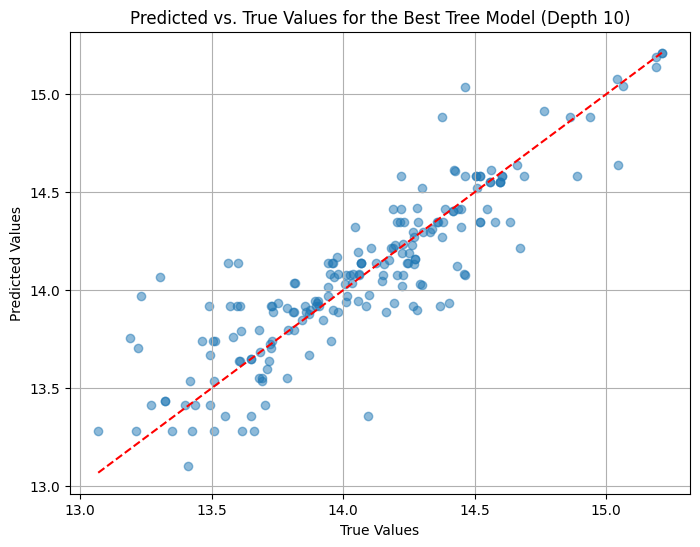

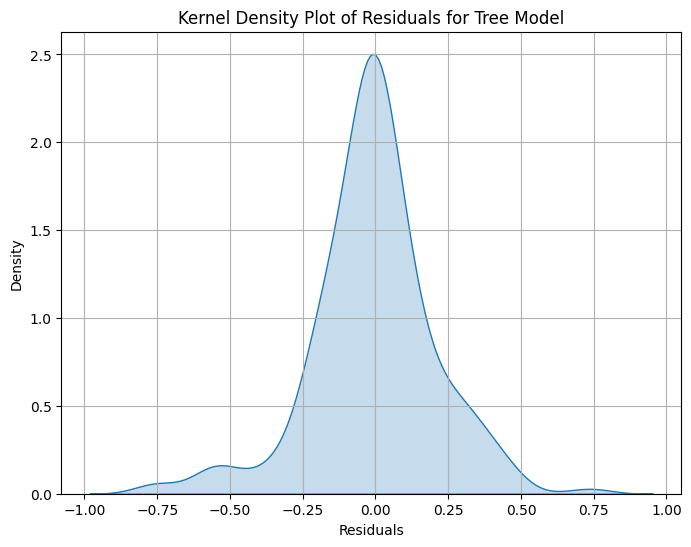

In [12]:
# Using the best tree model for evaluation
y_pred_best_tree = best_tree_model.predict(X_test_combined)

# Plotting predicted vs. true values for the best tree model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best_tree, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line for reference
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values for the Best Tree Model (Depth 10)')
plt.grid(True)
plt.show()

# Calculating residuals and plotting their distribution
residuals_tree = y_test - y_pred_best_tree
plt.figure(figsize=(8, 6))
sns.kdeplot(residuals_tree, fill=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Residuals for Tree Model')
plt.grid(True)
plt.show()


Predicted vs. True Values:

The scatter plot for the decision tree model shows the relationship between the true and predicted values.

A significant number of points are close to the diagonal line, indicating a good fit. However, the fit is not as tight as the linear model, suggesting some variability in the model's predictions.

Residuals Distribution

The kernel density plot of the residuals (differences between the true and predicted values) for the tree model is centered around zero, but it is less symmetric compared to the linear model's residuals.

The distribution is not as bell-shaped, indicating the presence of more significant errors in some predictions.

Comparison with the Linear Model
The best linear model (combined model) had an R2R^2R2 of 0.82 and an RMSE of 0.186.
The best decision tree model had an R2R^2R2 of 0.77 and an RMSE of 0.21.

The linear model outperforms the decision tree model on the test set in terms of both R2R^2R2 and RMSE. The linear model's predictions are more accurate and its errors are more normally distributed, suggesting better overall performance. The decision tree model, while effective, shows more variability and larger errors in some predictions.

**Q2.** The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

  1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.
  2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set? 
  3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?
  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?
  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4? 
  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?
  7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?
  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high 
    - Husband's education (categorical) 1=low, 2, 3, 4=high 
    - Number of children ever born (numerical) 
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv('./data/contraception_hw.csv')
df = df.drop(['Unnamed: 0'],axis=1)
print( np.sum(df.isnull()))
df.head()

age                      0
edu                      0
edu_spouse               0
numberChildren           0
religion                 0
working                  0
spouse_occupation        0
standardOfLivingIndex    0
mediaExposure            0
method                   0
dtype: int64


/Users/carlosrevilla/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,age,edu,edu_spouse,numberChildren,religion,working,spouse_occupation,standardOfLivingIndex,mediaExposure,method
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


The tabulation of the method variable in the contraceptive method

No Contraception: 629 cases
Long Term Contraception: 511 cases
Short Term Contraception: 333 cases
The cross-tabulation of method and numberChildren shows how the number of children varies with the contraceptive method used. It suggests that:

Couples with No Contraception: Tend to have a wider range of children numbers, with a significant number having 1 to 3 children. However, there are also cases with up to 16 children.
Couples using Long Term Contraception: Also have a range of children numbers, but the highest frequencies are observed for 3 to 5 children.
Couples using Short Term Contraception: Mostly have 2 to 4 children, with frequencies decreasing as the number of children increases.
From this data, it appears that couples who use birth control (both long term and short term) tend to have fewer children on average than those who don't use any contraception.

In [20]:
# Tabulating the 'method' variable
method_counts = df['method'].value_counts()

# Cross-tabulating 'method' and 'numberChildren' --! rename variables
cross_tabulation = pd.crosstab(df['method'], df['numberChildren'])
method_counts.index = ['No Contraception', 'Long Term', 'Short Term']
method_counts, cross_tabulation


(No Contraception    629
 Long Term           511
 Short Term          333
 Name: count, dtype: int64,
 numberChildren  0    1    2    3   4   5   6   7   8   9   10  11  12  13  16
 method                                                                       
 1               95  143  114   70  57  44  35  18  29   5   9   6   4   0   0
 2                0   46   56   70  62  36  27  19   9   3   2   2   0   1   0
 3                2   87  106  119  78  55  30  12   9   8   0   3   0   1   1)

A linear probability model is not suitable for this exercise because it predicts a probability outcome using a linear function, which can produce probabilities outside the 0 to 1 range. This is inappropriate for a categorical prediction problem with more than two categories. Additionally, linear probability models do not handle non-linear relationships and interactions between variables effectively, which are often crucial in categorical data analysis. The classification tree model, on the other hand, can naturally handle these aspects and produce probabilities confined within the 0 to 1 range, making it a more suitable choice for this type of analysis.

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent 
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where 
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?